# Install packages

In [1]:
!pip install catboost
!pip install bayesian-optimization
!pip install merf
!pip install shap

# Load packages

In [ ]:
%matplotlib inline

import seaborn as sn
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

my_seed=11

import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(my_seed)
import re
import random
random.seed(my_seed)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import catboost as cgb

from bayes_opt import BayesianOptimization

from statistics import mean

import warnings
warnings.filterwarnings("ignore")

from sklearn.inspection import plot_partial_dependence

import pickle
from merf.merf import MERF
import shap
shap.initjs()

import io
import os
import shutil
from typing import List, Dict, Tuple, Union

ModuleNotFoundError: ignored

# 0. Define helper functions

## 0.1 Define a function for **feature encoding**

In [ ]:
def feat_encoder(all_features: pd.DataFrame, num_feat_names: List, cat_feat_names: List, target: pd.DataFrame, rand_seed: int, retain_cat=False,**kwargs):
    """may want to try target encoding later"""

    features = all_features.copy()

    """check if there is any feature that needs to be dropped"""
    try:
        features.drop(kwargs['col_to_drop'],axis=1,inplace=True)
    except KeyError:
        pass
    
    # update numeric and categorical feature list
    num_feat_names = list(set(num_feat_names).intersection (set(list(features.columns))))
    cat_feat_names = list(set(cat_feat_names).intersection (set(list(features.columns))))
    
    # if exception for ohe is provided, leave out the corresponding feature(s): these feature(s) will not be encoded
    if 'ohe_exception_lst' in kwargs.keys():
        for ohe_except in kwargs['ohe_exception_lst']:
            cat_feat_names.remove(ohe_except)
          
    
    """separate train,test datasets"""
    X_train,X_test,y_train,y_test=train_test_split(features,target,random_state=rand_seed)
    #print (X_train.head())
    
    """Standardize numerical feature"""
    #ss=StandardScaler()
    #X_train[num_feat_names]=ss.fit_transform(X_train[num_feat_names])
    #X_test[num_feat_names]=ss.transform(X_test[num_feat_names])

    # check if need to retain categorical variables as-is: [CAUTION] this will retain ALL categorical features as-is, not individually
    if not(retain_cat):
        #print (cat_feat_names)
        """do label encoding for split data sets"""
        le=LabelEncoder()
        for col in cat_feat_names:
            if X_train[col].dtype == 'object':
                X_train[col] = le.fit_transform(X_train[col])
                X_test[col] = le.transform(X_test[col]) 
                integer_mapping = {l: i for i, l in enumerate(le.classes_)} #https://stackoverflow.com/questions/50834820/get-the-label-mappings-from-label-encoder
                print (f"mapping of label encoding for {col} is: ", integer_mapping, "\n")

        """OneHot Encoding for categorical features"""
        # if some categorical feature only need label encoding, drop them from cat_feat_names before ohe
        if 'le_only_lst' in kwargs:
            for feat in kwargs['le_only_lst']:
                cat_feat_names.remove(feat)
        
        ohe = OneHotEncoder(handle_unknown='ignore')
        tmp_X_train_category = ohe.fit_transform(X_train[cat_feat_names]).toarray()
        ohe_col_names = ohe.get_feature_names(cat_feat_names) #get encoded column names
        X_train = pd.concat([X_train.reset_index(),pd.DataFrame(tmp_X_train_category,columns=ohe_col_names)],axis=1)
        tmp_X_test_category = ohe.transform(X_test[cat_feat_names]).toarray() #transform the corresponding col in X_test
        X_test = pd.concat([X_test.reset_index(),pd.DataFrame(tmp_X_test_category,columns=ohe_col_names)],axis=1)
            
        ##remove original features
        X_train.drop(cat_feat_names,axis=1,inplace=True)
        X_test.drop(cat_feat_names,axis=1,inplace=True)
        
        ##drop the 'index' column
        X_train.drop('index',axis=1,inplace=True)
        X_test.drop('index',axis=1,inplace=True)


        final_col_names = list(ohe_col_names) + list(num_feat_names) #obtain the names of all encoded features
        final_cat_feat_names = list(ohe_col_names)
    else:
        final_col_names = cat_feat_names + num_feat_names #obtain the names of all encoded features
        final_cat_feat_names = cat_feat_names
        
    print (f"shape of X_train_encoded and X_test_encoded are: ", (X_train.shape, X_test.shape),"\n")
    print (f"shape of y_train and y_test are: ", (y_train.shape, y_test.shape),"\n")
    print ("cat features", final_cat_feat_names,"\n")
    print ("final features",final_col_names,"\n")
    

    return X_train,X_test,y_train,y_test,final_cat_feat_names,final_col_names

## 0.2 Define a function for training multiple models

In [ ]:
# can try 'storm tuner' library later: https://medium.com/geekculture/finding-best-hyper-parameters-for-deep-learning-model-4df7a17546c2

def multi_model(model_algorithm_dataset_dict: Dict, rand_seed: int, default_hyper_params=True, n_iter=1, **kwargs):
    """ prepare some variables """
    r2_model_FeatImportance_dict={} # a dict { r2: (model_name, feature_importance) }
    
    if default_hyper_params:    
        """ loop over all models """
        for model_name, algorithm_data_tuple in model_algorithm_dataset_dict.items():
            """ loop over iterations """
            for i in range(n_iter):
                """ loop over all datasets (i.e., multiple datasets can be fed to this function to train model) """        
                for j in range(len(algorithm_data_tuple[1])): 
                    # prepare the train and test data
                    X = algorithm_data_tuple[1][j][0] #2nd element in 'algorithm_data_tuple' is the (j) nested lists of [d_base[X_train,X_test,y_train,y_test,final_cat_feat_names],...
                                                    #,d_geo4]; assign X_train to X
                    y = algorithm_data_tuple[1][j][2] #assign y_train to y
                    X_test = algorithm_data_tuple[1][j][1] 
                    y_test = algorithm_data_tuple[1][j][3]
                    cat_feat_names = algorithm_data_tuple[1][j][4]
                    final_col_names = algorithm_data_tuple[1][j][5]

                    # specify the categorical features, if CatGB is selected
                    if model_name == 'CatBoostRegressor':
                        categorical_features_indices = [X.columns.get_loc(cat_feat) for cat_feat in cat_feat_names]
                    
                    # create an object, fit (k-fold validation) and make prediction
                    regr_obj = algorithm_data_tuple[0] #1st element in 'algorithm_data_tuple' is the actual algorithm            
                    kf = KFold(random_state=rand_seed, shuffle=True)
                    score_lst = []

                    # k-fold validation
                    for train_ix, test_ix in kf.split(X):
                        X_train_tmp, X_test_tmp = X.iloc[train_ix], X.iloc[test_ix]
                        y_train_tmp, y_test_tmp = y.iloc[train_ix], y.iloc[test_ix]

                        # fit the model
                        try: #if CatGB is selected
                            regr_obj.fit(X_train_tmp,y_train_tmp,cat_features=categorical_features_indices)
                        except:
                            regr_obj.fit(X_train_tmp,y_train_tmp)

                        # make prediction and add score to the list 
                        score_lst.append(r2_score(y_test_tmp,regr_obj.predict(X_test_tmp)))

                        # print out the average training score
                        print ("Default hyperparams, out of ", len(score_lst), "folds, ", f"average r2 of {model_name} from K-Fold validation is: ",mean(score_lst),"\n")

                    # pickle the model
                    pkl_filename = f"pickle_{model_name}_{j}th dataset.pkl"
                    with open(pkl_filename, 'wb') as file:
                        pickle.dump(regr_obj, file)
                        
                    # store the test score
                    r2_test = r2_score(y_test, regr_obj.predict(X_test))
                    # store the score on entire dataset
                    X_reunited = pd.concat([X,X_test])
                    y_reunited = pd.concat([y,y_test])
                    r2_whole = r2_score(y_reunited,regr_obj.predict(X_reunited))
                    
                    # get feature importance from the best model
                    feat_importances = pd.Series(regr_obj.feature_importances_ , index=final_col_names)
                    #print (feat_importances)
                        
                    print (f"{i}th iteration, {j}th dataset, the test r2 of {model_name} is: ", r2_test,"\n")
                    print (f"{i}th iteration, {j}th dataset, the r2 of {model_name} on ENTIRE dataset is: ", r2_whole,"\n")
                    print (f"{i}th iteration, {j}th dataset, the AVERAGE groundtruth value of {model_name} is: ", np.average(y_test),"\n")
                    print (f"{i}th iteration, {j}th dataset, the AVERAGE predicted value of {model_name} is: ", np.average(regr_obj.predict(X_test)),"\n")
                    print (f"{i}th iteration, {j}th dataset, the RMSE of {model_name} is: ", sqrt(mean_squared_error(y_test,regr_obj.predict(X_test))),"\n""\n")
                    # /////
                    # plt.plot(regr_obj.predict(X_test))
                   
                    if model_name == 'RandomForestRegressor':
                      fig = plt.figure("RandomForestRegressor")
                      plt.title({model_name})
                      y_test=y_test.reset_index(drop=True, inplace=False)
                      # print(y_test)
                      plt.plot(y_test)
                      plt.plot(regr_obj.predict(X_test))
                    if model_name == 'CatBoostRegressor':
                      fig = plt.figure("CatBoostRegressor")
                      plt.title({model_name})
                      y_test=y_test.reset_index(drop=True, inplace=False)
                      # print(y_test)
                      plt.plot(y_test)
                      plt.plot(regr_obj.predict(X_test))
                    if model_name == 'LGBMRegressor':
                      fig = plt.figure("LGBMRegressor")
                      plt.title({model_name})
                      y_test=y_test.reset_index(drop=True, inplace=False)
                      # print(y_test)
                      plt.plot(y_test)
                      plt.plot(regr_obj.predict(X_test))
                    # print(regr_obj.predict(X_test))
                    # print('y_test!!!!!', type(y_test))
                    # print('y_predict!!!!!', type(regr_obj.predict(X_test)))
                    # print('y_predict shape!!!!!', regr_obj.predict(X_test).shape())

                    

                    # print(regr_obj.predict(X_test).shape)
                    
                    # ///////
                    # add information
                    r2_model_FeatImportance_dict[r2_test] = (model_name,f"{j}th dataset",feat_importances,pkl_filename, [X,y])
                    #print ( r2_model_FeatImportance_dict)
                    
    else:    
        """ with hyperparams tuning """
        assert isinstance(kwargs['hyperparams_range_dict'],dict) #check if the nested dict { model_name1: {hparam1: x, hparam2: y,...hparamX: z},... } is provided
        
        """ loop over all models """
        for model_name, algorithm_data_tuple in model_algorithm_dataset_dict.items():
            
            # special handling for CatGB
            if model_name == 'CatBoostRegressor':
                """define a helper function for CatGB"""
                def hyp_cat(depth,bagging_temperature):
                    params={'iterations':300,
                            'learning_rate':0.05,
                            'eval_metric': 'R2',
                            'verbose':False,    
                    }

                    params['depth']=int(round(depth))
                    params['bagging_temperature']=bagging_temperature
                    params['loss_function']= "RMSE"
                    scores_cgb=cgb.cv(cv_dataset,params,fold_count=5)
                    
                    return np.max(scores_cgb['test-R2-mean'])
                    
                # prepare other variables
                pds={'depth': kwargs['hyperparams_range_dict']['CatBoostRegressor']['depth'],
                     'bagging_temperature':kwargs['hyperparams_range_dict']['CatBoostRegressor']['bagging_temperature'],
                    }
                print( kwargs['hyperparams_range_dict']['CatBoostRegressor']['depth'])
                


            """ loop over iterations """
            for i in range(n_iter):   
                """loop over all datasets (i.e., base, cluster, geoclass6, geoclass3,geoclass4)"""        
                for j in range(len(algorithm_data_tuple[1])): 
                    # prepare the train and test data
                    X_train = algorithm_data_tuple[1][j][0] #2nd element in 'algorithm_data_tuple' is the (j) nested lists of [d_base[X_train,X_test,y_train,y_test,final_cat_feat_names],...
                                                    #,d_geo4]; 
                    y_train = algorithm_data_tuple[1][j][2] 
                    X_test = algorithm_data_tuple[1][j][1] 
                    y_test = algorithm_data_tuple[1][j][3]
                    cat_feat_names = algorithm_data_tuple[1][j][4]
                    final_col_names = algorithm_data_tuple[1][j][5]

                    # special handling for CatGB
                    if model_name == 'CatBoostRegressor':
                        categorical_features_indices = [X_train.columns.get_loc(cat_feat) for cat_feat in cat_feat_names]
                        cv_dataset = cgb.Pool(data=X_train,label=y_train,cat_features=categorical_features_indices)
                        #internal_params_CatGB={k:v for k,v in kwargs['hyperparams_range_dict']['CatBoostRegressor'].items() if k in ['iterations','learning_rate','eval_metric',
                                                                                                                          #'verbose']}
                        #create an optimizer model
                        optimizer = BayesianOptimization(hyp_cat,pds) #hyp_cat and pds are defined where 'model_name' is first identified

                        #optimize
                        try:
                            optimizer.maximize(init_points=3,n_iter=7)
                            best_params = optimizer.max['params']
                            print ("Hyperparams of the best model: ", best_params)
                        except ValueError as err:
                            print (f"{err}")
                            print ("The following is skpped: ","\n", f"{i}th iteration, {j}th dataset, {model_name}","\n")
                            continue
                        
                        # create the CatGB object with optimal hyperparams
                        # [caution] make sure 'verbose' and 'n_estimators' have the same values as those in no hyperparams tuning case
                        regr_obj = CatBoostRegressor(random_state=rand_seed,verbose=0,n_estimators=2000,bagging_temperature=optimizer.max['params']['bagging_temperature'],depth=int(round(optimizer.max['params']['depth'])))

                        # fit the model
                        regr_obj.fit(X_train,y_train,cat_features=categorical_features_indices)
                    else:
                        # create an object and make prediction
                        regr_obj = algorithm_data_tuple[0] #1st element in 'algorithm_data_tuple' is the actual algorithm 

                        # do the random search CV
                        regr_obj_random = RandomizedSearchCV(estimator = regr_obj, param_distributions = kwargs['hyperparams_range_dict'][model_name], 
                                                             n_iter = 100, cv = 5, scoring='r2',verbose=2, random_state=rand_seed, n_jobs = -1)
                        regr_obj_random.fit(X_train,y_train)

                        # assign the best model back to regr_obj
                        regr_obj = regr_obj_random.best_estimator_
                        best_params  =regr_obj_random.best_params_ #save the hyperparams of the best model
                        print ("Hyperparams of the best model: ", best_params)
                        
                        # do the training based on the best model
                        regr_obj.fit(X_train,y_train)
                        
                    # pickle the model
                    pkl_filename = f"pickle_{model_name}_{j}th dataset.pkl"
                    with open(pkl_filename, 'wb') as file:
                        pickle.dump(regr_obj, file)
                        
                    # get feature importance from the best model
                    feat_importances = pd.Series(regr_obj.feature_importances_ , index=final_col_names)

                    # store the test score
                    r2_test = r2_score(y_test, regr_obj.predict(X_test))
                    # store the score on entire dataset
                    X_reunited = pd.concat([X_train,X_test])
                    y_reunited = pd.concat([y_train,y_test])
                    r2_whole = r2_score(y_reunited,regr_obj.predict(X_reunited))
                    
                    print (f"{i}th iteration, {j}th dataset, the test r2 of {model_name} is: ", r2_test,"\n")
                    print (f"{i}th iteration, {j}th dataset, the r2 of {model_name} on ENTIRE dataset is: ", r2_whole,"\n")
                    print (f"{i}th iteration, {j}th dataset, the AVERAGE groundtruth value of {model_name} is: ", np.average(y_test),"\n")
                    print (f"{i}th iteration, {j}th dataset, the AVERAGE predicted value of {model_name} is: ", np.average(regr_obj.predict(X_test)),"\n")
                    print (f"{i}th iteration, {j}th dataset, the RMSE of {model_name} is: ", sqrt(mean_squared_error(y_test,regr_obj.predict(X_test))),"\n""\n")
                    if model_name == 'RandomForestRegressor':
                      fig = plt.figure("RandomForestRegressor")
                      plt.title({model_name})
                      y_test=y_test.reset_index(drop=True, inplace=False)
                      # print(y_test)
                      plt.plot(y_test)
                      plt.plot(regr_obj.predict(X_test))
                    if model_name == 'CatBoostRegressor':
                      fig = plt.figure("CatBoostRegressor")
                      plt.title({model_name})
                      y_test=y_test.reset_index(drop=True, inplace=False)
                      # print(y_test)
                      plt.plot(y_test)
                      plt.plot(regr_obj.predict(X_test))
                    if model_name == 'LGBMRegressor':
                      fig = plt.figure("LGBMRegressor")
                      plt.title({model_name})
                      y_test=y_test.reset_index(drop=True, inplace=False)
                      # print(y_test)
                      plt.plot(y_test)
                      plt.plot(regr_obj.predict(X_test))

                    ##add information
                    r2_model_FeatImportance_dict[r2_test]=(model_name,f"{j}th dataset",feat_importances,pkl_filename,[X_train,y_train])
       
    
    # """ feature importance from best model """
    # # identify the feature importance from the best model
    # tmp_r2 = 0
    # for r2 in list(r2_model_FeatImportance_dict.keys()):
    #     tmp_r2 = max(tmp_r2,r2)
    # model_w_highest_r2 = r2_model_FeatImportance_dict[tmp_r2][0] #points to 'model_name'
    # data_set_w_highest_r2 = r2_model_FeatImportance_dict[tmp_r2][1] #points to corresponding 'jth dataset'
    # feat_importances_best = r2_model_FeatImportance_dict[tmp_r2][2] #points to corresponding 'feat_importances'
    # best_pickle_name = r2_model_FeatImportance_dict[tmp_r2][3] #points to the name of the pickled best model
    # best_train_Xy_data = r2_model_FeatImportance_dict[tmp_r2][4] #points to the [X_train, y_train] data that was used to train the best model
    # #print (feat_importances_best)

    # # save the best performing model
    # src = os.path.sep.join([os.getcwd(),f"{best_pickle_name}"])
    # dst = os.path.sep.join([os.getcwd(),f"BEST_performing_model.pkl"])
    # shutil.copy(src,dst)
   
    
    # # plot and save the feature importance
    # print (f"the feature importance (top 15) of the model with highest r2 ({tmp_r2}), {model_w_highest_r2} & {data_set_w_highest_r2}, is shown below: \n")
    # feat_importances_best.nlargest(15).plot(kind='barh')
    
    # fig = feat_importances_best.nlargest(15).plot(kind='barh').get_figure()
    # fig.savefig('feature_importance from best model.png')
    
    
    """ partial dependence plot from best model 
    # prepare best model
    best_model = pickle.load(open(best_pickle_name, 'rb'))
    #print (f"r2 of PICKLED BEST model using ALL of its own training dataset: ",r2_score(best_train_Xy_data[1],best_model.predict(best_train_Xy_data[0])),"\n")
    
    #[Caution] seems you'll have to fit the loaded model for CatBoost again before using PDP (no such a need for RF or LightGBM)
    #best_model.fit( best_train_Xy_data[0], best_train_Xy_data[1])-->this won't work for CatBoost, as it does not use the standard sklearn API
    
    # plot PDP using PDP plot from sklearn
    plot_partial_dependence(best_model,  best_train_Xy_data[0], list(feat_importances_best.index),n_jobs=-1, grid_resolution=20)
    

    
    # adjust size, display and save figure
    fig=plt.gcf()
    fig.set_size_inches(16,10)
    print (f"Partial dependence plot for {model_w_highest_r2} & {data_set_w_highest_r2} is shown below: \n")
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    fig.savefig(f"PDP from best model_{model_w_highest_r2} & {data_set_w_highest_r2}.png")
    """

# 1.0 Data **pre-processsing**

In [ ]:
file_name = 'EU-ECB_dataset_feature_engineered.csv' # file name MUST match the file selected for upload

# load data file from local drive
from google.colab import files
uploaded = files.upload()

raw_all = pd.read_csv(file_name)

Saving EU-ECB_dataset_feature_engineered.csv to EU-ECB_dataset_feature_engineered.csv


NameError: ignored

In [ ]:
# convert data file into dataframe
# raw_all = pd.read_csv(io.BytesIO(uploaded[file_name]))

In [ ]:
print(raw_all.shape)
raw_all.keys()
print(type(raw_all))

## 1.1 Feature screening and engineering

In [ ]:
raw_all.head()

In [ ]:
raw_all.columns

### **Define the scope of analysis**

In [ ]:
""" define the scope of analysis """
raw_df = raw_all[raw_all.bldg_project_status.isin(['New Built', 'In use'])]

# Sub-sets
raw_df_DK = raw_df[raw_df.site_country.isin(['Denmark']) & raw_df.admin_project_contact.isin(['BUILD', 'Ramboll'])]
raw_df_FR = raw_df[raw_df.site_country.isin(['France']) & raw_df.admin_project_contact.isin(['CSTB'])]
raw_df_BE = raw_df[raw_df.site_country.isin(['Belgium']) & raw_df.admin_project_contact.isin(['KU Leuven'])]
raw_df_NL = raw_df[raw_df.site_country.isin(['Netherlands']) & raw_df.admin_project_contact.isin(['NIBE'])]
raw_df_FI = raw_df[raw_df.site_country.isin(['Finland']) & raw_df.admin_project_contact.isin(['Granlund Oy', 'Bionova'])]

raw_df_A72 = raw_df[raw_df.admin_project_contact.isin(['ROECK-et-al', 'AMIRI-et-al'])]

raw_df_EUECB = raw_df_DK.append([raw_df_FR, raw_df_BE, raw_df_NL, raw_df_FI])

# assign final sub-set to raw_df for further processing
raw_df = raw_df_EUECB

In [ ]:
raw_df

In [ ]:
print(raw_df_DK.shape)
print(raw_df.shape)

In [ ]:
# print(type(raw_df_DK))
# print(raw_df_DK.head())

In [ ]:
target_col_set = {col for col  in raw_df.columns if col.startswith('GHG')}
missing_data_percent_dict = {col: raw_df[col].isnull().sum()/len(raw_df[col]) for col in target_col_set }
print(target_col_set)
missing_threshold = 0.5
target_col_set_retained = {col for col in target_col_set if missing_data_percent_dict[col] <= missing_threshold}
print(target_col_set_retained)
print(list(target_col_set-target_col_set_retained))

## **Decide target column(s) to keep**

In [ ]:
""" decide target column(s) to keep """
# remove the columns with too much missing data
target_col_set = {col for col  in raw_df.columns if col.startswith('GHG')}
missing_data_percent_dict = {col: raw_df[col].isnull().sum()/len(raw_df[col]) for col in target_col_set }
print(missing_data_percent_dict)
missing_threshold = 0.5
target_col_set_retained = {col for col in target_col_set if missing_data_percent_dict[col] <= missing_threshold}
#print(target_col_set_retained)

# update the dataframe
data_updated = raw_df.drop(list(target_col_set-target_col_set_retained), axis=1)
print([col for col in data_updated.columns if col.startswith('GHG')])

## **Decide feature columns to keep**

In [ ]:
""" decide feature columns to keep """
# remove the columns with too much missing data
feat_col_set = {col for col in data_updated.columns if col not in target_col_set_retained}
feat_col_set_retained = {col for col in feat_col_set if data_updated[col].isnull().sum()/len(data_updated[col]) <= missing_threshold}
#print(feat_col_set_retained)

# further screening
# further_removal_set = {'admin_','site_country','scope_','lca_database','lca_software'}
further_removal_set = {'admin_','scope_','lca_database','lca_software'}

for start_str in further_removal_set:
  feat_col_set_retained = {col for col in feat_col_set_retained if not col.startswith(start_str)}

# update the dataframe
data_updated = data_updated.drop(list(feat_col_set-feat_col_set_retained), axis=1)

# exam the retained features
data_updated

In [ ]:
type(data_updated)

In [ ]:
# correlation screening
# a python package to remove collinearity: https://towardsdatascience.com/a-python-library-to-remove-collinearity-5a4eb05d3d73

# variance screening

# remove the rows containing NaN in feature and/or target columns
data_updated.dropna(inplace=True)
data_updated

# create a dict to store dtype of each column
dtype_dict = {col: data_updated[col].dtype for col in data_updated.columns}
dtype_dict

In [ ]:
data_updated.shape

### **MIXED EFFECT RANDOM FOREST (MERF)**

In [ ]:
features_=data_updated[list(feat_col_set_retained)]
cat_feat_names=[col for col in features_.columns if data_updated[col].dtype == 'object']
num_feat_names=[feat for feat in features_.columns if feat not in cat_feat_names]
target_=data_updated['GHG_sum_em']

# get data into a list
X_train,X_test,y_train,y_test,final_cat_feat_names,final_col_names = feat_encoder(features_,num_feat_names,cat_feat_names,
                                                           target_,rand_seed=my_seed,ohe_exception_lst=['site_country'], retain_cat=False) #set retain_cat=True if wanting to use catboost, include cat features in analysis
## merge train and test datasets...
train_merged=pd.concat([X_train,y_train.reset_index(drop=True)],axis=1)
train_merged['site_country'].replace(['France','Denmark','Finland','Belgium','Netherlands'],[1,2,3,4,5], inplace=True)
# train_merged.head()

test_merged=pd.concat([X_test,y_test.reset_index(drop=True)],axis=1)
test_merged['site_country'].replace(['France','Denmark','Finland','Belgium','Netherlands'],[1,2,3,4,5], inplace=True)

# test_merged.head()



In [ ]:
train_merged.head()

In [ ]:
test_merged.head()

In [ ]:
type(train_merged)

pandas.core.frame.DataFrame

In [ ]:
""" data preparation """
## training data
train_col_to_drop=['GHG_sum_em']

X_train_input=train_merged.drop(train_col_to_drop,axis=1)


X_train_input=train_merged
Z_train = np.ones((len(train_merged), 1))
clusters_train=train_merged['site_country']
y_train_input=train_merged['GHG_sum_em']

## test data
X_test_input=test_merged
Z_test = np.ones((len(test_merged), 1))
clusters_test=test_merged['site_country']
y_test_input=test_merged['GHG_sum_em']

In [ ]:
clusters_train.unique()

array([1])

In [ ]:
""" training """
## reset random seed
np.random.seed(my_seed)
random.seed(my_seed)

## do KFold on training X and y data
mrf = MERF() #max_iterations=100
cv = KFold(n_splits=5, shuffle=True)
score_lst=[]

for train_ix, test_ix in cv.split(X_train_input):
    X_train_tmp,X_test_tmp=X_train_input.iloc[train_ix],X_train_input.iloc[test_ix]
    Z_train_tmp,Z_test_tmp=Z_train[train_ix],Z_train[test_ix]
    clusters_train_tmp,clusters_test_tmp=clusters_train.iloc[train_ix],clusters_train.iloc[test_ix]
    y_train_tmp,y_test_tmp=y_train_input.iloc[train_ix],y_train_input.iloc[test_ix]
     
    # fit model
    mrf.fit(X_train_tmp, Z_train_tmp, clusters_train_tmp, y_train_tmp)

    # make prediction and add score to the list 
    score_lst.append(r2_score(y_test_tmp,mrf.predict(X_test_tmp,Z_test_tmp, clusters_test_tmp)))

    # print out the average training score
    print ("Default hyperparams, out of ", len(score_lst), "folds, ", "average r2 of MERF from K-Fold validation is: ",mean(score_lst),"\n")


Default hyperparams, out of  1 folds,  average r2 of MERF from K-Fold validation is:  0.970145328921568 

Default hyperparams, out of  2 folds,  average r2 of MERF from K-Fold validation is:  0.9805191782694787 

Default hyperparams, out of  3 folds,  average r2 of MERF from K-Fold validation is:  0.9472573709950574 

Default hyperparams, out of  4 folds,  average r2 of MERF from K-Fold validation is:  0.959538201185484 

Default hyperparams, out of  5 folds,  average r2 of MERF from K-Fold validation is:  0.9460029817710621 



In [ ]:
""" test """
r2_test=r2_score(y_test_input, mrf.predict(X_test_input, Z_test,clusters_test))
print ("test r2 on test samples is: ", r2_test,"\n")
print ("the AVERAGE groundtruth value is: ", np.average(y_test_input),"\n")
print ("the AVERAGE predicted value is: ", np.average(mrf.predict(X_test_input, Z_test,clusters_test)),"\n")
print ("the RMSE: ", sqrt(mean_squared_error(y_test_input,mrf.predict(X_test_input, Z_test,clusters_test))),"\n""\n")
print ("the Mean Absolute percentage Error (MAPE): ", np.average(100*abs((y_test_input-mrf.predict(X_test_input, Z_test,clusters_test))/y_test_input)),"\n""\n")


test r2 on test samples is:  0.762442926697394 

the AVERAGE groundtruth value is:  508506.5656250001 

the AVERAGE predicted value is:  407962.4222494003 

the RMSE:  369250.2685504421 


the Mean Absolute percentage Error (MAPE):  10.835105110038683 




# **Plot (MERF)**

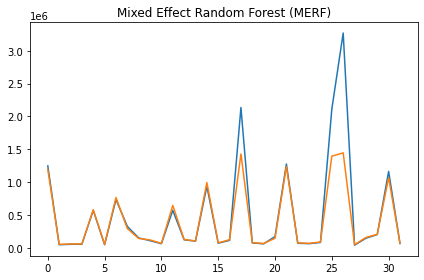

In [ ]:
fig = plt.figure("Mixed Effect Random Forest (MERF)")
plt.title("Mixed Effect Random Forest (MERF)")
# y_test=y_test.reset_index(drop=True, inplace=False)
# print(y_test)
plt.plot(y_test_input)
plt.plot(mrf.predict(X_test_input, Z_test,clusters_test))